# Mini Project 1: MNSIT Pair Comparison

In [420]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Imports from the folder we created
from Utils.DataImport import DataImport #import data import class
from Utils.errs import compute_nb_errors_pred as errorr # import error function
from Utils.Networks import CNN_SP #import network object

import warnings
#warnings.filterwarnings('ignore')



In [421]:
#set to use CPU or GPU automatically based on what is available
def select_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = select_device()
print('Device is',device)

Device is cpu


In [422]:
# instantiate data importer class and get training and test data dicts
D = DataImport(device)
Train, Test = D.Train, D.Test

train_input = Train["Train Input"]
test_input = Test["Test Input"]

train_classes = Train["Train Classes"]
test_classes = Test["Test Classes"]

train_target = Train["Train Target"]
test_target = Test["Test Target"]

# convert classes from Nx2 to Nx20, decimal image labels to binary
train_classes_binary = Train["Train CB"] 
test_classes_binary = Test["Test CB"]

In [423]:
# function to compute aux accuracy
def accuracy_classes(predicted, target):
    
    '''
    computes the accuracy of the predicted classes in %
    '''
    predicted_1 = predicted.narrow( 1, 0, 10)
    predicted_2 = predicted.narrow( 1, 10, 10)
    target_1 = target.narrow( 1, 0, 10)
    target_2 = target.narrow( 1, 10, 10)
    predicted_1 = predicted_1.argmax(dim=1)
    predicted_2 = predicted_2.argmax(dim=1)
    target_1 = target_1.argmax(dim=1)
    target_2 = target_2.argmax(dim=1)
    return ( 100-( ( (target_1 != predicted_1) | (target_2 != predicted_2 ) ).sum() ).item() /target_1.shape[0] * 100 ,  (target_1 != predicted_1) | (target_2 != predicted_2 ))

# test:
print(accuracy_classes( model(test_input.narrow(0,0,5))[0], test_classes_binary.narrow(0,0,5))  ) 
accuracy_classes( test_classes_binary.narrow(0,0,5), test_classes_binary.narrow(0,0,5))    

(0.0, tensor([1, 1, 1, 1, 1], dtype=torch.uint8))


(100.0, tensor([0, 0, 0, 0, 0], dtype=torch.uint8))

In [424]:
# see if the model predict allways the same classes
for i in range(20):
    print(model(test_input.narrow(0,0,10))[0].narrow(1,0,10).argmax(dim=1))

tensor([3, 8, 6, 1, 7, 9, 0, 1, 0, 0])
tensor([2, 9, 5, 1, 7, 8, 0, 1, 0, 0])
tensor([3, 9, 6, 1, 6, 9, 8, 1, 0, 0])
tensor([3, 9, 6, 4, 7, 2, 0, 1, 8, 0])
tensor([2, 9, 6, 1, 7, 8, 4, 6, 0, 0])
tensor([3, 9, 6, 1, 7, 9, 0, 1, 5, 0])
tensor([3, 9, 6, 1, 7, 9, 0, 1, 0, 0])
tensor([3, 9, 6, 1, 7, 8, 0, 1, 0, 0])
tensor([3, 9, 5, 1, 7, 9, 4, 1, 4, 0])
tensor([3, 9, 6, 1, 7, 8, 0, 1, 0, 0])
tensor([3, 8, 6, 4, 7, 9, 0, 1, 0, 0])
tensor([3, 9, 6, 4, 7, 8, 0, 1, 0, 0])
tensor([3, 9, 6, 1, 7, 9, 0, 1, 0, 0])
tensor([3, 9, 6, 1, 7, 9, 0, 1, 0, 5])
tensor([3, 9, 6, 1, 7, 8, 0, 1, 0, 0])
tensor([3, 8, 6, 1, 7, 9, 0, 4, 0, 0])
tensor([3, 9, 6, 1, 7, 2, 6, 1, 0, 4])
tensor([3, 9, 6, 1, 7, 9, 5, 5, 5, 5])
tensor([3, 9, 6, 4, 7, 8, 0, 1, 0, 0])
tensor([2, 9, 6, 1, 7, 9, 0, 1, 5, 0])


In [445]:
# Training of the model






eta= 0.0005
mini_batch_size = 100
epochs = 200

penalty =1

# use created network as model, cross entropy as main criterion, and MSE loss as aux criterion
model, criterion_main, criterion_aux = CNN_SP(), nn.CrossEntropyLoss(reduction='mean'), nn.MSELoss(),#net with weight sharing and classification
model, criterion_main, criterion_aux = model.to(device), criterion_main.to(device), criterion_aux.to(device), 

# use adam optimizer for SGD
optimizer = torch.optim.Adam(model.parameters(), lr=eta)



        
# learning curve arrays
train_L_sum ,train_L_main, train_L_aux, L, main_validation_L, aux_validation_L = [], [], [], [], [], []
main_validation_acc, test_acc, aux_validation_acc, train_acc, aux_train_acc = [], [], [], [], []

print('epoch: (../ '+str(epochs)+' )')
for e in range(0, epochs):
    print(str(e), sep=' ', end=' ', flush=True)
    sum_loss = 0
    # We do this with mini-batches
    for b in range(0, train_input.size(0), mini_batch_size):

        mini_batch_input = train_input.narrow(0, b, mini_batch_size)
        mini_batch_target = train_target.narrow(0, b, mini_batch_size) #classification labels Nx1
        mini_batch_target_aux = train_classes_binary.narrow(0, b, mini_batch_size) #binary 'what number are these images' Nx20


        #output_aux is the Nx20 output of the second fc layer corresponding to what image pairs were predicted
        #output is the Nx2 output corresponding to: if image 0 or image 1 is bigger
        output_aux, output = model(mini_batch_input)  


        loss_aux = criterion_aux(output_aux, mini_batch_target_aux) #image pair detection loss
        loss_main = criterion_main(output, mini_batch_target) #classification loss with crossentropy
        
        loss = loss_aux #+ loss_main

        sum_loss = sum_loss + loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b ==900:
            train_L_main.append(loss_main.item())
            train_L_aux.append(loss_aux.item())
            train_L_sum.append(loss.item())

            # compute validation loss and accuracys
            with torch.no_grad():
                # Validate on a mini_batch only
                mini_batch_test_input = test_input.narrow(0, 0, mini_batch_size)
                mini_batch_test_target = test_target.narrow(0, 0, mini_batch_size)
                mini_batch_test_classes = test_classes_binary.narrow(0, 0, mini_batch_size)

                #compute outputs for test data
                validation_output_aux, validation_output = model(mini_batch_test_input)

                # compute loss for test data
                main_validation_loss = criterion_main(validation_output, mini_batch_test_target)
                aux_validation_loss = criterion_aux(validation_output_aux, mini_batch_test_classes)

                # compute accuracy for test and train data
                main_validation_acc_item = 100 - errorr(model, test_input, test_target, mini_batch_size)[0]  / test_input.size(0) * 100
                aux_validation_acc_item = accuracy_classes(validation_output_aux, mini_batch_test_classes)[0]
                main_train_acc_item = 100 - errorr(model, train_input, train_target, mini_batch_size)[0]  / train_input.size(0) * 100
                aux_train_acc_item = accuracy_classes(output_aux, mini_batch_target_aux)[0]
                
                # append to arrays
                main_validation_L.append(main_validation_loss.item())
                aux_validation_L.append(aux_validation_loss.item())
                main_validation_acc.append(main_validation_acc_item)
                aux_validation_acc.append(aux_validation_acc_item)
                train_acc.append(main_train_acc_item)
                aux_train_acc.append(aux_train_acc_item)
        # these two penalties do almost nothing
        '''
        with torch.no_grad():
            for p in model.parameters():
                p.sub_(p.sign()*p.abs().clamp(max=0.00001))

        with torch.no_grad():
            for p in model.parameters():
                loss += penalty * p.pow(2).sum()
            '''    



epoch: (../ 200 )
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

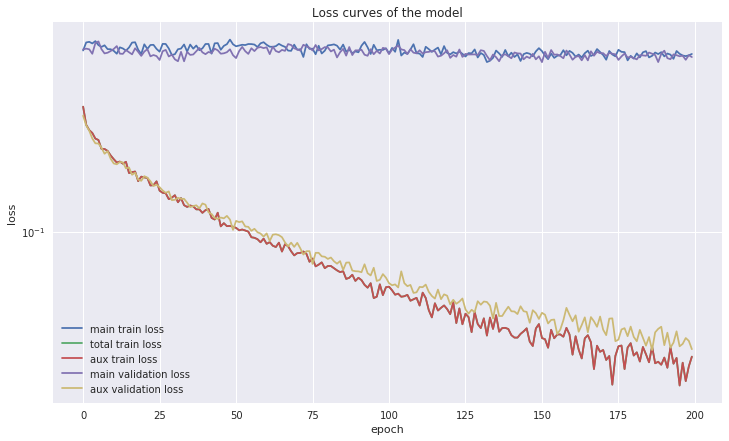

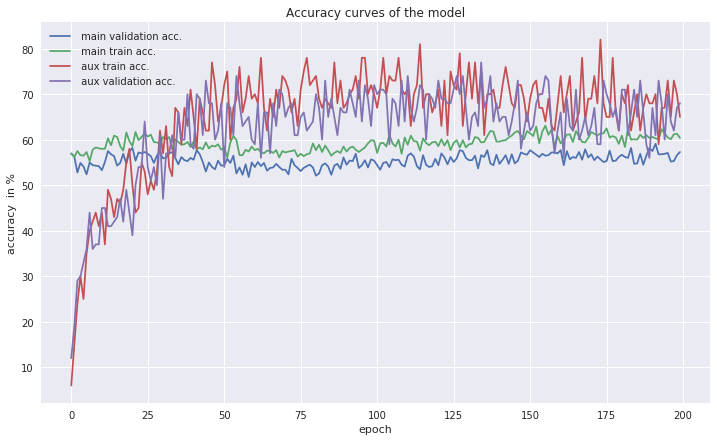

In [446]:
plt.figure(figsize=(12,7))
plt.plot(train_L_main, label='main train loss')
plt.plot(train_L_sum, label='total train loss')
plt.plot(train_L_aux, label='aux train loss')
plt.plot(main_validation_L, label='main validation loss')
plt.plot(aux_validation_L, label='aux validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Loss curves of the model')
plt.show()


plt.figure(figsize=(12,7))
plt.plot(main_validation_acc, label=' main validation acc.')
plt.plot(train_acc, label=' main train acc.')
plt.plot(aux_train_acc, label=' aux train acc.')
plt.plot(aux_validation_acc, label=' aux validation acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy  in %')
plt.title('Accuracy curves of the model')
plt.show()

In [427]:
train_e, train_pred = errorr(model, train_input, train_target, mini_batch_size)

test_e, test_pred = errorr(model, test_input, test_target, mini_batch_size)

print('Train error:', train_e/train_input.size(0))

print('Test error:', test_e/test_input.size(0))

print('Number of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad)) 

Train error: 0.633
Test error: 0.636
Number of parameters: 95928


# Take a look at the input vs prediction

### TRAIN

In [428]:
train_target[:100]

tensor([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1])

In [429]:
train_pred[0] #predicted pairs in training for first mini batch of 100

#first 15 elements of each vector below are left and right columns above, repsectively

tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1])

Print image pairs if you want

In [430]:
#for i in range(10):
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(train_input[i,0,:,:].cpu(), cmap='gray', interpolation='none')
#    ax2.imshow(train_input[i,1,:,:].cpu(), cmap='gray', interpolation='none')

#    plt.show()

In [431]:
#train_classes_binary_0[:10]

In [432]:
#train_classes_binary_1[:10]

### TEST

In [433]:
test_target[:100]

tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1])

In [434]:
test_pred[0] #predicted pairs in testing for first mini batch of 100

tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1])

Primt image pairs if you want

In [435]:
#for i in range(10):
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(test_input[i,0,:,:].cpu(), cmap='gray', interpolation='none')
#    ax2.imshow(test_input[i,1,:,:].cpu(), cmap='gray', interpolation='none')

#    plt.show()

In [436]:
#test_classes_binary_0[:10]

In [437]:
#test_classes_binary_1[:10]